# Install packages & Get Imports

In [1]:
# !pip install pandasql
# !pip install nbformat


In [2]:
import pprint
import sqlite3
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots

# Connect to dataset and create the data frames

In [3]:
con = sqlite3.connect("../../../data/mental_health.sqlite")

questions_df = pd.read_sql_query("SELECT * from Question", con)

answers_df = pd.read_sql_query("SELECT * from Answer", con)
answers_df.columns = ['AnswerText', 'SurveyID',	'UserID', 'questionid']

surveys_df = pd.read_sql_query("SELECT * from Survey", con)

# Form a singular df with all present Q&As
qa = pd.merge(answers_df, questions_df, how='left', on='questionid')

# Get a list of all survey years
survey_years = list(surveys_df["SurveyID"])


# Gender in Tech

- Using 3 genders
    - Male
    - Female
    - Other

Gender distribution: 

{'female': [251, 341, 219, 129, 100],
 'male': [996, 1059, 504, 269, 228],
 'other': [13, 33, 33, 19, 24]}


<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/n2/d4wp9tmj61j7ywkmw1k5bpg40000gn/T/ipykernel_5288/3147945708.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "male" or key is "female":                                    # Annotating points only for male and female as the other numbers are very less
/var/folders/n2/d4wp9tmj61j7ywkmw1k5bpg40000gn/T/ipykernel_5288/3147945708.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "male" or key is "female":                                    # Annotating points only for male and female as the other numbers are very less


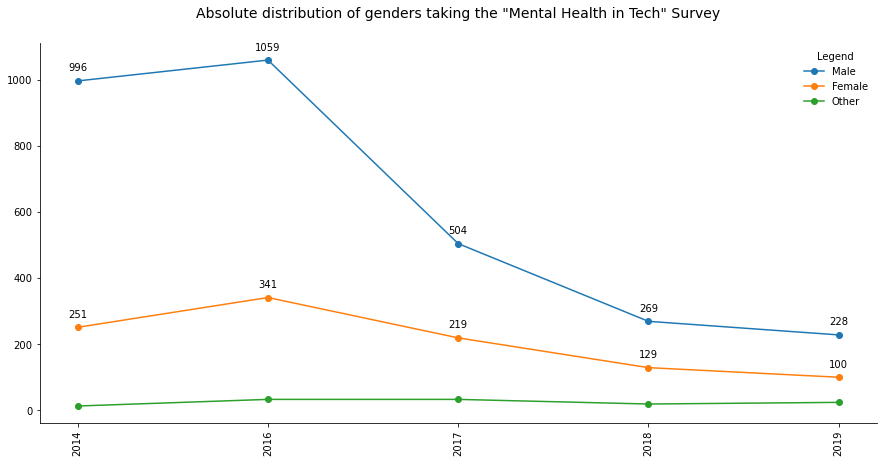

In [4]:
gender_through_years = qa.query("questionid == 2")

temp_groupby = None
gender_distribution = \
{
    "male": [0, 0, 0, 0, 0],
    "female": [0, 0, 0, 0, 0],
    "other": [0, 0, 0, 0, 0]
}

for idx, year in enumerate(surveys_df["SurveyID"]):
    temp = gender_through_years[gender_through_years["SurveyID"] == year]
    temp_groupby = temp.groupby('AnswerText').count()


    for answer, row in temp_groupby.iterrows():
        if "female" in answer.lower() or "she" in answer.lower() or "femina" in answer.lower():                                                           
            gender_distribution["female"][idx] = gender_distribution["female"][idx] + row[1]
        elif "male" in answer.lower() or "guy" in answer.lower() or "swm" in answer.lower() or "masculino" in answer.lower():                                                           
            gender_distribution["male"][idx] = gender_distribution["male"][idx] + row[1]
        else:
            gender_distribution["other"][idx] = gender_distribution["other"][idx] + row[1]



print(f"Gender distribution: \n")
pprint.pprint(gender_distribution)

plt.figure(figsize=(15,7))
for key in gender_distribution.keys():
    plt.plot(gender_distribution.get(key), "o-", label=key.title().replace("_", " "))
    
    if key is "male" or key is "female":                                    # Annotating points only for male and female as the other numbers are very less
        for x in range(len(survey_years)):
            plt.annotate(gender_distribution.get(key)[x], # this is the text
                         (x, gender_distribution.get(key)[x]), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') # horizontal alignment can be left, right or center


plt.legend(title="Legend", frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(range(len(survey_years)), survey_years, rotation=90)
plt.title(label="Absolute distribution of genders taking the \"Mental Health in Tech\" Survey",
          fontsize=14,
          y=1.05
         )
plt.show()


# Age groups & Countries taking the survey

In [5]:
age_group = qa.query("questionid == 1")[["SurveyID", "AnswerText"]]
print("-"*50, "\nBefore Filtering\n", "-"*50, sep="")
print(f"Minimum age: ", age_group["AnswerText"].astype("int").min())
print(f"Maximum age: ", age_group["AnswerText"].astype("int").max())
print(f"Mean age: ", round(age_group["AnswerText"].astype("int").mean(), 2))
print(f"Median age: ", age_group["AnswerText"].astype("int").median())
print()

x = age_group[(age_group.SurveyID == year) & \
                               (age_group.AnswerText.astype("int") >= 15) & \
                               (age_group.AnswerText.astype("int") <= 90)]
print("-"*50, "\nAfter Filtering\n", "-"*50, sep="")
print(f"Minimum age: ", x["AnswerText"].astype("int").min())
print(f"Maximum age: ", x["AnswerText"].astype("int").max())
print(f"Mean age: ", round(x["AnswerText"].astype("int").mean(), 2))
print(f"Median age: ", x["AnswerText"].astype("int").median())

--------------------------------------------------
Before Filtering
--------------------------------------------------
Minimum age:  -29
Maximum age:  329
Mean age:  33.92
Median age:  33.0

--------------------------------------------------
After Filtering
--------------------------------------------------
Minimum age:  19
Maximum age:  64
Mean age:  35.6
Median age:  34.0


Text(0.5, 0.98, 'Age Distribution of Participants Taking The Survey')

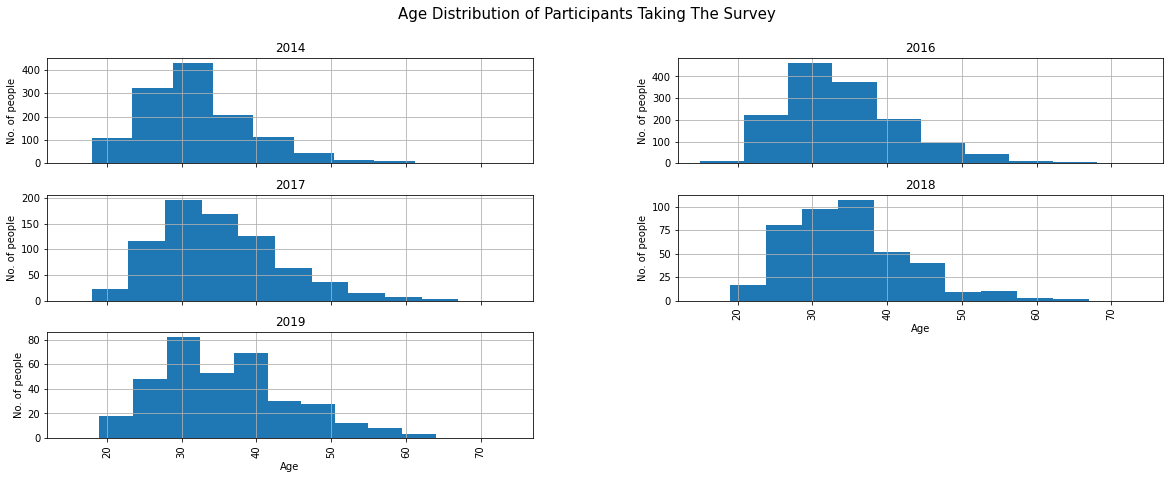

In [6]:
age_group = qa.query("questionid == 1")[["SurveyID", "AnswerText"]]
age_dict = {}

for year in survey_years:
#     print("Working with year: ", year)
    age_dict[year] = age_group[(age_group.SurveyID == year) & \
                               (age_group.AnswerText.astype("int") >= 15) & \
                               (age_group.AnswerText.astype("int") <= 90)] \
                        .AnswerText \
                        .astype("int") \
                        .sort_values() \
                        .tolist()
    
axarr = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in age_dict.items() ])) \
        .hist(
            figsize=(20,7), 
            xrot=90,sharex=True
        )
for ax in axarr.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("No. of people")
    
plt.suptitle("Age Distribution of Participants Taking The Survey", fontsize=15)

In [7]:
country_df = qa.query("questionid == 3")[["SurveyID", "AnswerText"]]
# country_df

country_dict = {}

for year in survey_years:
#     print("Working with year: ", year)
    year_country_df = country_df[(country_df.SurveyID == year)]
    value_counts = year_country_df.value_counts()
    temp_dict = {}
    
    for country_name, country_no in zip(value_counts.index, value_counts):
        country_name = country_name[1]  ## Subscript [1] is used to deal with the multi index part. Print the following to understand better: 'year_country_df.value_counts().index'
        
        # Handle USA separately since the name changed in the survey and both the values are present in the answer
        if country_name == "United States" or  country_name == "United States of America":
            temp_dict["USA"] = int(country_no)

        else:
            temp_dict[country_name] = int(country_no)
    
    country_dict[year] = temp_dict
#     break

country_df = pd.DataFrame(country_dict)
display(country_df)

,2014,2016,2017,2018,2019
USA,751.0,840.0,497.0,312.0,204.0
United Kingdom,185.0,180.0,66.0,19.0,32.0
Canada,72.0,78.0,26.0,8.0,15.0
Germany,45.0,58.0,22.0,7.0,4.0
Netherlands,27.0,48.0,14.0,5.0,4.0
...,...,...,...,...,...
Mauritius,NaN,NaN,NaN,1.0,NaN
Macedonia,NaN,NaN,NaN,1.0,NaN
Hong Kong,NaN,NaN,NaN,1.0,1.0
Ethiopia,NaN,NaN,NaN,1.0,NaN


In [8]:
for column in country_df.columns:
    count_df = country_df[column] \
                .sort_values(ascending=False)
    count_df_others_sum = count_df[6:].sum()
    temp_df = count_df.head(5)
    temp_df.loc["Others"] = count_df_others_sum

    
    
    fig = px.pie(temp_df,
            values=column, 
            names=temp_df.index,
            title="Top 5 countries taking the survey "+str(column),
            labels={
                "index":"Country"
            })
    fig.show()

# How many people are actually willing to seek out treatment within the tech industry?

In [9]:
seek_help_yoy = qa.query("questionid == 7")

percent_yoy = []
tot_yoy = []
for year in survey_years:
    tmp = seek_help_yoy[(seek_help_yoy.SurveyID == year)][["AnswerText", "UserID", "SurveyID"]]
    tmp2 = tmp.AnswerText.value_counts()
    
    percent_yoy.append((tmp2.loc["1"] / (tmp2.loc["1"]+tmp2.loc["0"])) * 100)    # Percentage of participant each year who seeked help
    tot_yoy.append((tmp2.loc["1"]+tmp2.loc["0"]))                                # Total no.  of participant each year who took part

In [10]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=survey_years, y=percent_yoy, name="% of participants seeking help"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=survey_years, y=tot_yoy, name="No. of participants"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Percent of participants seeking help YoY",
    template="plotly_dark"
)

# Set x-axis title
fig.update_xaxes(title_text="Survey Year")

# Set y-axes titles
fig.update_yaxes(title_text="% of participants seeking help", secondary_y=False)
fig.update_yaxes(title_text="No. of participants", secondary_y=True)

fig.show()

# Employment Status - Corporate vs Self Employed

In [11]:
# Employment Status
employment_df = qa.query("questionid == 5")[["AnswerText", "UserID"]].set_index('UserID')
employment_df = employment_df[employment_df['AnswerText'] != '-1'] 

print(f"How many total people work in an enterprise: {employment_df.value_counts()[0]}")
print(f"How many total people are self employed: {employment_df.value_counts()[1]}")


# Diagnosed Status
diagnosed_df = qa.query("questionid == 34")[["AnswerText", "UserID"]].set_index('UserID')
diagnosed_df = diagnosed_df[diagnosed_df['AnswerText'] != '-1']                                

print(f"No. of people diagnosed with a mental health illness: {diagnosed_df.value_counts()[0]}")
print(f"No. of people NOT diagnosed with a mental health illness: {diagnosed_df.value_counts()[1]}")

# Join employment with diagnosed and group by on employment 
emp_diag_join = employment_df.join(diagnosed_df,
                     on="UserID",
                     how="inner",
                     lsuffix="_employment",
                     rsuffix='_diagnosed')
# Drop the index
emp_diag_join.reset_index(drop=True, inplace=True)

How many total people work in an enterprise: 3550
How many total people are self employed: 650
No. of people diagnosed with a mental health illness: 1363
No. of people NOT diagnosed with a mental health illness: 732


In [12]:
# Separate all the values
corp_diag = emp_diag_join.value_counts()[0]
print(f"Enterprise and diagnosed: {corp_diag}")

corp_notdiag = emp_diag_join.value_counts()[1]
print(f"Enterprise and not diagnosed: {corp_notdiag}")

self_diag = emp_diag_join.value_counts()[2]
print(f"Self employed and diagnosed: {self_diag}")

self_notdiag = emp_diag_join.value_counts()[3]
print(f"Self employed and not diagnosed: {self_notdiag}")

Enterprise and diagnosed: 1128
Enterprise and not diagnosed: 591
Self employed and diagnosed: 235
Self employed and not diagnosed: 141


In [13]:
fig = px.bar([[corp_diag, corp_notdiag], [self_diag, self_notdiag]],
            labels={
                "variable":"Diagnosed",
                "value":"Count",
                "index":"Self employed?"
            })

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext = ['Working at a corporate', 'Self employed']
    ),
    title="Does working in a corporate cause more mental health issues?",
    xaxis_title="",
    yaxis_title="Count",
    
    template="plotly_dark"
)

fig.update_layout(showlegend=False)
fig.show()